<h1>Loss Function with a High Condition Number with and Without Momentum</h1>

<h2>Table of Contents</h2>
<p>In this lab, we will generate data that will produce a Loss Function with a High Condition Number. You will create two models; one with the momentum term and one without the momentum term.</p>

<ul>
    <li><a href="#Makeup_Data">Make Some Data </a></li>
    <li><a href="#Model_Cost">Create two Models, Two Optimizers and a Cost Function</a></li>
    <li><a href="#BGD">Train the Model: Batch Gradient Descent</a></li>
</ul>
<p>Estimated Time Needed: <strong>30 min</strong></p>

<hr>

<h2>Preparation</h2>

In [1]:
# Import the libraries we need for this lab

import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim

torch.manual_seed(1)

In [2]:
# Define the class for plot out the surface

class plot_error_surfaces(object):
    
    # Constructor
    def __init__(self, w_range, b_range, X, Y, n_samples=30, go=True):
        W = np.linspace(-w_range, w_range, n_samples)
        B = np.linspace(-b_range, b_range, n_samples)
        w, b = np.meshgrid(W, B)    
        Z = np.zeros((n_samples, n_samples))
        count1 = 0
        self.y = Y.numpy()
        self.x = X.numpy()
        for w1, b1 in zip(w, b):
            count2 = 0
            for w2, b2 in zip(w1, b1):
                Z[count1, count2] = np.mean((self.y - w2 * self.x + b2) ** 2)
                count2 += 1
            count1 += 1
        self.Z = Z
        self.w = w
        self.b = b
        self.LOSS_list = {}
    
    # Setter
    def set_para_loss(self, model, name, loss):
        if (not (name in self.LOSS_list)):
            self.LOSS_list[name] = []
        w = list(model.parameters())[0].item()
        b = list(model.parameters())[1].item()
        self.LOSS_list[name].append({"loss": loss, "w": w, "b": b})
        
    # Plot the diagram
    def plot_ps(self, iteration=0):
        plt.contour(self.w, self.b, self.Z)
        count = 1
        if (len(self.LOSS_list) > 0):
            for key, value in self.LOSS_list.items():
                w = [v for d in value for (k, v) in d.items() if "w" == k]
                b = [v for d in value for (k, v) in d.items() if "b" == k]
                plt.scatter(w, b, cmap='viridis', marker='x', label=key)
            plt.title('Loss Surface Contour not to scale, Iteration: ' + str(iteration))
            plt.legend()
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()

<h2 id="Makeup_Data">Make Some Data</h2>

Generate values from -2 to 2 that create a line with a slope of 0.1 and a bias of 10000. This is the line that you need to estimate. Add some noise to the data:

In [3]:
# Define a class to create the dataset

class Data(Dataset):
    
    # Constructor
    def __init__(self):
        self.x = torch.arange(-2, 2, 0.1).view(-1, 1)
        self.f = 1 * self.x + 10000
        self.y = self.f + 0.1 * torch.randn(self.x.size())
        self.len = self.x.shape[0]
        
    # Getter
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len

In [4]:
# Create a dataset object

dataset = Data()

In [7]:
dataset[0]

(tensor([-2.]), tensor([9997.8477]))

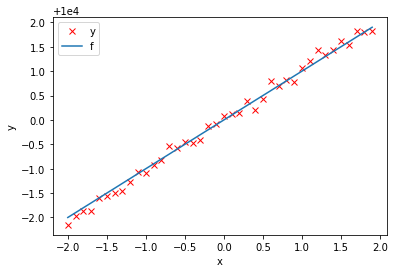

In [8]:
# Plot the data

plt.plot(dataset.x.numpy(), dataset.y.numpy(), 'rx', label='y')
plt.plot(dataset.x.numpy(), dataset.f.numpy(), label='f')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

<h2 id="Model_Cost">Create the Model and Total Loss Function (Cost)</h2>

In [9]:
# Define linear regression class

class linear_regression(nn.Module):
    
    # Constructor
    def __init__(self, input_size, output_size):
        super(linear_regression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    # Prediction
    def forward(self, x):
        yhat = self.linear(x)
        return yhat

In [10]:
# Use the build-in function to create a criterion function

criterion = nn.MSELoss()

In [11]:
# Create a linear regression object and the optimizer without momentum

model = linear_regression(1, 1)
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [12]:
# Create a linear regression object and the optimizer with momentum

model_momentum = linear_regression(1, 1)
optimizer_momentum = optim.SGD(model_momentum.parameters(), lr=0.01, momentum=0.2)

In [13]:
# Create a data loader

trainloader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)

PyTorch randomly initializes your model parameters. If we use those parameters, the result will not be very insightful as convergence will be extremely fast. In order to prevent that, we will initialize the parameters such that it will take longer to converge.

In [14]:
model.state_dict()['linear.weight'][0] = -5000
model.state_dict()['linear.bias'][0] = -100000
model_momentum.state_dict()['linear.weight'][0] = -5000
model_momentum.state_dict()['linear.bias'][0] = -100000

In [20]:
model.state_dict()['linear.weight'][0]

tensor([-5000.])

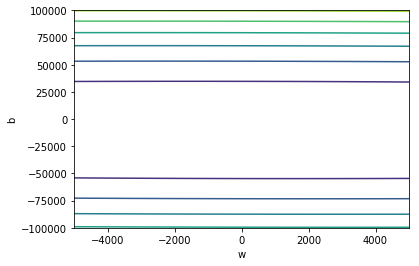

In [21]:
# Plot the surface

get_surface = plot_error_surfaces(5000, 100000, dataset.x, dataset.y, 100, go=False)
get_surface.plot_ps()

<h2 id="BGD">Train the Model via Stochastic Gradient Descent</h2>

Run 1 epochs of stochastic gradient descent and view parameter space. 

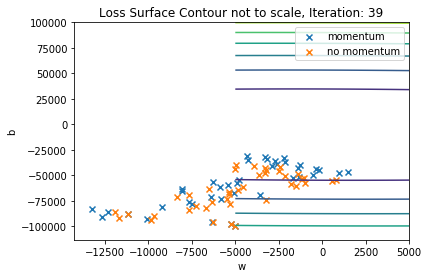

In [22]:
# Train the model

def train_model(epochs=1):
    for epoch in range(epochs):
        for i, (x, y) in enumerate(trainloader):
            #no momentum
            yhat = model(x)
            loss = criterion(yhat, y)

            #momentum
            yhat_m = model_momentum(x)
            loss_m = criterion(yhat_m, y)

            #apply optimization to momentum term and term without momentum 

            #for plotting 
            #get_surface.get_stuff(model, loss.tolist())
            #get_surface.get_stuff1(model_momentum, loss_m.tolist())

            get_surface.set_para_loss(model=model_momentum, name="momentum" ,loss=loss_m.tolist())
            get_surface.set_para_loss(model=model, name="no momentum" , loss=loss.tolist())

            optimizer.zero_grad()
            optimizer_momentum.zero_grad()
            loss.backward()
            loss_m.backward()
            optimizer.step()
            optimizer_momentum.step()
        get_surface.plot_ps(iteration=i)
train_model()

The plot above shows the different parameter values for each model in different iterations of SGD. The values are overlaid over the cost or total loss surface. The contour lines somewhat miss scaled but it is evident that in the vertical direction they are much closer together implying a larger gradient in that direction. The model trained with momentum shows somewhat more displacement in the hozontal direction.

The plot below shows the log of the cost or total loss, we see that the term with momentum converges to a minimum faster and to an overall smaller value. We use the log to make the difference more evident.

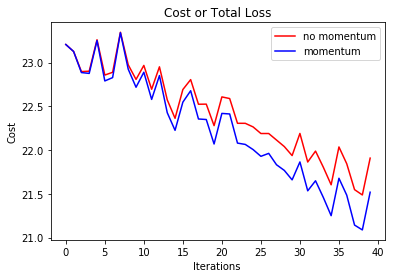

In [23]:
# Plot the loss

loss = [v for d in get_surface.LOSS_list["no momentum"] for (k, v) in d.items() if "loss" == k]
loss_m = [v for d in get_surface.LOSS_list["momentum"] for (k, v) in d.items() if "loss" == k]
plt.plot(np.log(loss), 'r', label='no momentum' )
plt.plot(np.log(loss_m), 'b', label='momentum' )
plt.title('Cost or Total Loss' )
plt.xlabel('Iterations ')
plt.ylabel('Cost')
plt.legend()
plt.show()